In [1]:
"""! pip install datasets
! pip install matplotlib
! pip install scikit-learn
! pip install spacy
! pip install nltk
! pip install pattern
! pip install wordcloud
! pip install gensim
"""
# ! python -m spacy download pt_core_news_sm
# ! python -m spacy download pt_core_news_lg

'! pip install datasets\n! pip install matplotlib\n! pip install scikit-learn\n! pip install spacy\n! pip install nltk\n! pip install pattern\n! pip install wordcloud\n! pip install gensim\n'

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import load_dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import re

## **Data Loading and Understanding**

In [3]:
dataset = load_dataset("higopires/RePro-categories-multilabel")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
# Ver número de exemplos em cada divisão do dataset
for split in dataset.keys():
    print(f"{split}: {len(dataset[split])} examples")

train: 8002 examples
validation: 994 examples
test: 1007 examples


In [5]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

train_data = pd.DataFrame(train_dataset)
val_data = pd.DataFrame(val_dataset)
test_data = pd.DataFrame(test_dataset)

In [6]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0


Checking the missing values

In [7]:
train_data.isnull().sum()

,0
review_text,0
ENTREGA,0
OUTROS,0
PRODUTO,0
CONDICOESDERECEBIMENTO,0
INADEQUADA,0
ANUNCIO,0


Example of some reviews

In [8]:
print(train_data["review_text"][2])

Entrega rápida, produto muito bom Amei. Praticidade


In [9]:
print(train_data["review_text"][7])

...................     ..........gdssdfhhbcxxxxvbjjnvvvvbbbbbvxfvhbbbnncftg


In [10]:
# check data type of review_text
print(type(train_data["review_text"][0]))
# check data type of label PRODUTO
print(type(train_data["PRODUTO"][0]))

<class 'str'>
<class 'numpy.int64'>


In [11]:
"""train_data['length'] = train_data['review_text'].apply(len)
train_data.head()"""

"train_data['length'] = train_data['review_text'].apply(len)\ntrain_data.head()"

In [12]:
# Obter as colunas (nomes dos labels)
columns = list(dataset["train"].features.keys())
labels = columns[1:]  # Excluindo 'review_text'

print("Labels:", labels)
print("Number of labels:", len(labels))

Labels: ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']
Number of labels: 6


In [13]:
# Label columns
label_cols = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

## **EDA**

{'PRODUTO': 6258, 'ENTREGA': 2488, 'OUTROS': 1885, 'CONDICOESDERECEBIMENTO': 1369, 'ANUNCIO': 699, 'INADEQUADA': 328}


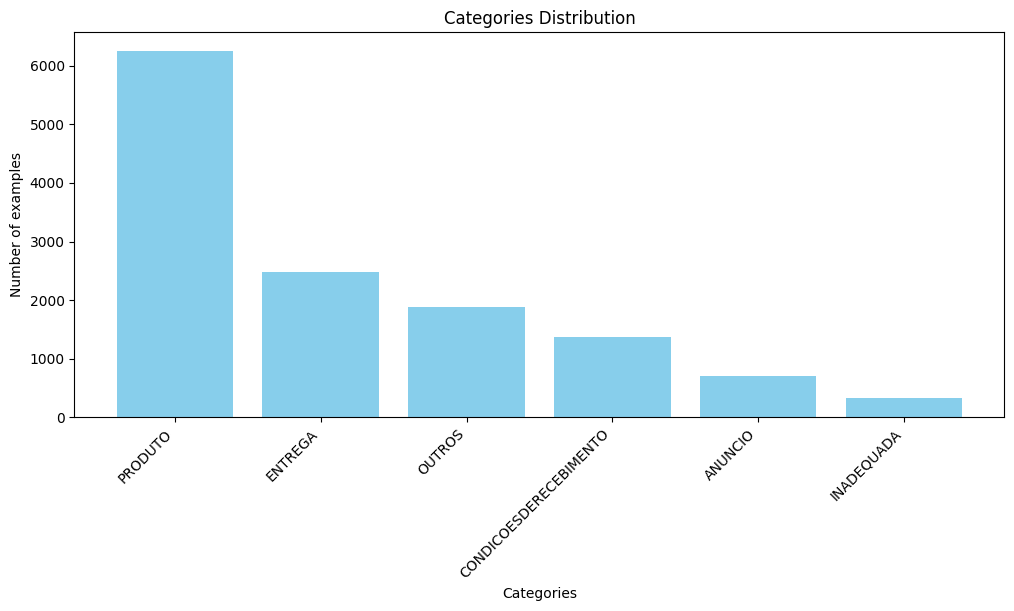

In [14]:
label_counts = train_data.iloc[:, 1:].sum()

# Ordenar por frequência
label_counts = dict(sorted(label_counts.items(), key=lambda item: item[1], reverse=True))

print(label_counts)

# Plotar gráfico
plt.figure(figsize=(12, 5))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categories")
plt.ylabel("Number of examples")
plt.title("Categories Distribution")
plt.show()

Number of labels per review distribution:
1    4188
2    2741
3     943
4     122
5       8
Name: count, dtype: int64


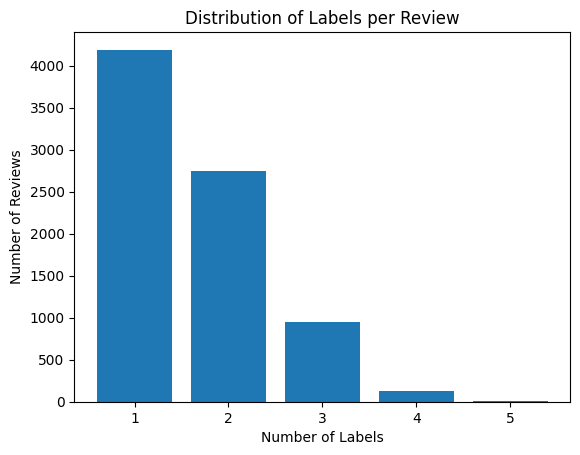

In [15]:
label_counts_per_review = train_data[label_cols].sum(axis=1)
print("Number of labels per review distribution:")
print(pd.Series(label_counts_per_review).value_counts())

plt.hist(label_counts_per_review, bins=range(1, 7), align='left', rwidth=0.8)
plt.title("Distribution of Labels per Review")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Reviews")
plt.show()

* 4188 reviews have exactly 1 label
* 2741 reviews have exactly 2 labels
* 943 reviews have exactly 3 labels
* 122 reviews have exactly 4 labels
* 8 reviews have exactly 5 labels

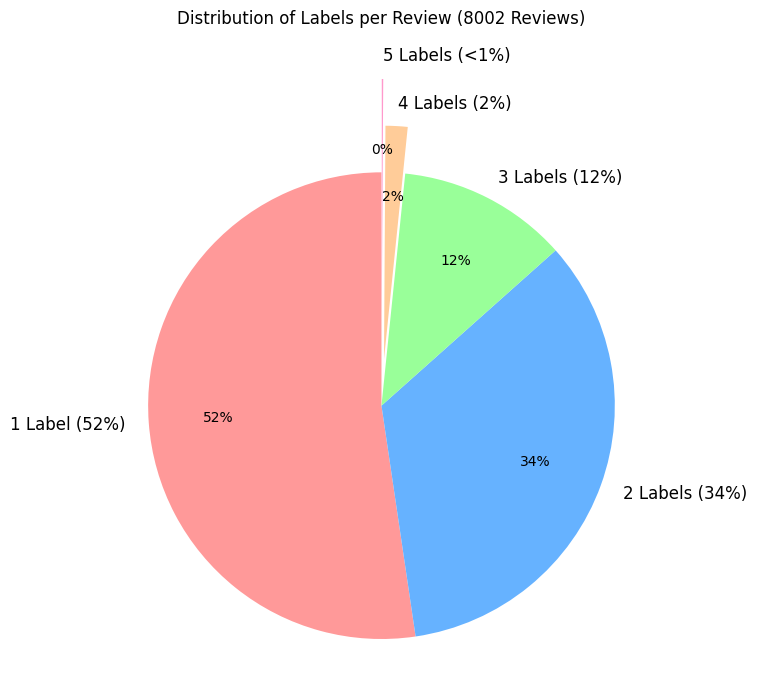

In [16]:
label_counts = label_counts_per_review.value_counts().values
total_reviews = 8002 # number of training examples
percentages = [count / total_reviews * 100 for count in label_counts]
labels = ['1 Label (52%)', '2 Labels (34%)', '3 Labels (12%)', '4 Labels (2%)', '5 Labels (<1%)']

# Create pie chart
plt.figure(figsize=(8, 8))
# Add explode to pull out small slices, and adjust label distance
explode = [0, 0, 0, 0.2, 0.4]  # Pull out 4 and 5 labels a bit
wedges, texts, autotexts = plt.pie(percentages, labels=labels, autopct='%1.0f%%', startangle=90,
                                   colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC'],
                                   explode=explode, labeldistance=1.1, pctdistance=0.7)

# Customize text for readability
for text in texts:
    text.set_fontsize(12)  # Bigger label text
for autotext in autotexts:
    autotext.set_fontsize(10)  # Bigger percentage text
    autotext.set_color('black')  # Black for contrast

plt.title("Distribution of Labels per Review (8002 Reviews)", pad=20)
plt.axis('equal')  # Keep it circular
plt.show()

In [17]:
text_lengths = [len(example["review_text"].split()) for example in dataset["train"]]

print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Maximum text length: {np.max(text_lengths)} words")
print(f"Minimum text length: {np.min(text_lengths)} words")

Average text length: 24.58 words
Maximum text length: 428 words
Minimum text length: 1 words


## **Preprocessing**

EXPERIMENTAR FAZER STEMMING!!

In [18]:
import spacy
import re
from nltk.stem import SnowballStemmer

# Load the Portuguese language model
nlp = spacy.load('pt_core_news_lg')

# Initialize the Snowball Stemmer for Portuguese
stemmer = SnowballStemmer("portuguese")

def preprocess_text(text, method="lemma"):
    """
    Preprocess text by applying lemmatization or stemming.

    Parameters:
    - text (str): Input text
    - method (str): "lemma" for lemmatization, "stem" for stemming

    Returns:
    - str: Preprocessed text
    """
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization and processing
    doc = nlp(text)

    if method == "lemma":
        tokens = [token.lemma_ for token in doc if not token.is_stop]
    elif method == "stem":
        tokens = [stemmer.stem(token.text) for token in doc if not token.is_stop]
    else:
        raise ValueError("Method must be 'lemma' or 'stem'")

    return ' '.join(tokens)

# Apply preprocessing with both methods to compare
train_data['lemmatized_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
train_data['stemmed_reviews'] = train_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

val_data['lemmatized_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
val_data['stemmed_reviews'] = val_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))

test_data['lemmatized_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="lemma"))
test_data['stemmed_reviews'] = test_data['review_text'].apply(lambda x: preprocess_text(x, method="stem"))


In [19]:
print("Original:", train_data['review_text'].iloc[0])
print("Lemmatized:", train_data['lemmatized_reviews'].iloc[0])
print("Stemmed:", train_data['stemmed_reviews'].iloc[0])

Original: Aparelho muito bom, confiável e com valor aquisitivo em conta, ou seja: tudo que a massa precisa!
Lemmatized: aparelho confiável aquisitivo conta ser massa precisar
Stemmed: aparelh confiável aquisit cont sej mass precis


In [20]:
train_data.head()

,review_text,ENTREGA,OUTROS,PRODUTO,CONDICOESDERECEBIMENTO,INADEQUADA,ANUNCIO,lemmatized_reviews,stemmed_reviews
0,"Aparelho muito bom, confiável e com valor aqui...",0,0,1,0,0,0,aparelho confiável aquisitivo conta ser massa ...,aparelh confiável aquisit cont sej mass precis
1,"A história é muito boa, porém o autor ""enrolou...",0,0,1,0,0,0,história autor enrolar livro,histór autor enrol livr
2,"Entrega rápida, produto muito bom Amei. Pratic...",1,0,1,0,0,0,entregar rápido produto amar praticidade,entreg ráp produt ame pratic
3,Produto otimo so falta o carregador da maquina...,0,0,1,1,0,0,produto otimo so carregador maquina pequeno,produt otim so carreg maquin pequen
4,a proteção anti queda não é boa se cair de fr...,0,0,1,0,0,0,proteção anti queda cair frente tela,proteçã anti qued cair frent tel


Part Of Speech (POS) serves to identify nouns, verbs, etc., and filtered to keep only certain POS tags (e.g., nouns) before feature extraction. We didn't apply POS, because lemmatization already simplifies terms and multi-label needs flexible features (not just nouns or adjectives), so this technique might be redundant.

## **Feature Extraction**

## **1- TF-IDF**

### **1.1- Unigram TF-IDF Vectorization**

In [21]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['lemmatized_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word
"""print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")"""

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 488.2262
recomendar: 234.1057
chegar: 203.3263
comprar: 199.9689
prazo: 194.0114
qualidade: 185.3566
gostar: 182.2771
entregar: 181.8631
entrega: 173.2043
rápido: 154.2068
excelente: 151.3629
bom: 146.1159
dia: 143.8600
recebi: 136.4783
vir: 136.1746
super: 119.6697
ótimo: 114.8176
atender: 106.3468
compra: 105.3768
pra: 98.0093


In [22]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit on the training data and transform it into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['lemmatized_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['lemmatized_reviews'])

# Check the shape of the TF-IDF features, these are sparse matrices containing the TF-IDF features for the training, validation, and test sets, respectively.
# each row is a document and each column is a word
"""print("Training data shape:", X_train_tfidf.shape)
print("Validation data shape:", X_val_tfidf.shape)
print("Test data shape:", X_test_tfidf.shape, end="\n\n")"""

# Sum the TF-IDF scores for each word across all documents
tfidf_scores = np.asarray(X_train_tfidf.sum(axis=0)).flatten()

# Get the feature names (words in the vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a dictionary of words and their corresponding TF-IDF scores
word_tfidf_scores = dict(zip(feature_names, tfidf_scores))

# Sort the words by their TF-IDF scores in descending order
sorted_words = sorted(word_tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words
print("Top 20 unigrams by TF-IDF score:")
for word, score in sorted_words[:20]:
    print(f"{word}: {score:.4f}")

Top 20 unigrams by TF-IDF score:
produto: 515.0546
recomendar: 248.2208
comprar: 213.9742
chegar: 212.4833
prazo: 202.6565
gostar: 194.4167
qualidade: 194.1893
entregar: 190.1552
entrega: 181.2094
rápido: 160.7322
excelente: 158.9161
bom: 153.6764
dia: 151.4586
vir: 142.9737
recebi: 142.9331
super: 125.7680
ótimo: 118.7558
atender: 111.8822
compra: 111.2379
pra: 103.6173


### **1.2- Bigram TF-IDF Vectorization**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2))  # Unigrams + bigrams

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['lemmatized_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['lemmatized_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 bigrams by TF-IDF score:
recebi produto: 55.4152
chegar prazo: 55.0975
produto chegar: 49.3651
gostar produto: 47.2966
entregar prazo: 47.2189
produto entregar: 41.0208
atender expectativa: 37.7258
ótimo qualidade: 37.1043
produto excelente: 34.6375
bom produto: 33.2058
produto qualidade: 32.6299
produto ótimo: 32.1825
excelente produto: 30.1993
entregar rápido: 29.5193
super recomendar: 29.4634
produto atender: 28.9780
produto vir: 28.8988
super rápido: 28.6211
valer pena: 28.4338
comprar produto: 27.4269


### **1.3- Unigram + Bigram TF-IDF Vectorization**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Define the TF-IDF vectorizer with unigrams and bigrams
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Unigrams + bigrams, exclude terms appearing in fewer than 2 times in order to reduce the feature space

# Fit and transform the training data
X_train_tfidf_bi = tfidf_bigram.fit_transform(train_data['lemmatized_reviews'])
# Transform the validation and test data
X_val_tfidf_bi = tfidf_bigram.transform(val_data['lemmatized_reviews'])
X_test_tfidf_bi = tfidf_bigram.transform(test_data['lemmatized_reviews'])

# Calculate the sum of TF-IDF scores for each feature (word/phrase)
tfidf_scores_bi = np.asarray(X_train_tfidf_bi.sum(axis=0)).flatten()
# Get the feature names (words/phrases)
feature_names_bi = tfidf_bigram.get_feature_names_out()
# Create a dictionary of words/phrases and their corresponding TF-IDF scores
word_tfidf_scores_bi = dict(zip(feature_names_bi, tfidf_scores_bi))
# Sort the words/phrases by their TF-IDF scores in descending order
sorted_words_bi = sorted(word_tfidf_scores_bi.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 unigrams and bigrams by TF-IDF score
print("\nTop 20 unigrams + bigrams by TF-IDF score:")
for word, score in sorted_words_bi[:20]:
    print(f"{word}: {score:.4f}")


Top 20 unigrams + bigrams by TF-IDF score:
produto: 356.8034
recomendar: 164.9192
comprar: 160.5778
chegar: 145.4203
gostar: 137.9903
qualidade: 131.3312
prazo: 131.2037
entregar: 125.6497
entrega: 120.5678
bom: 109.9173
dia: 109.1038
vir: 107.8224
excelente: 106.4761
rápido: 105.7967
recebi: 101.3937
super: 85.7864
pra: 79.7878
ótimo: 79.4835
atender: 78.4346
compra: 78.0960


There's only single words in the top 20 TF-IDF scores for unigrams + bigrams, because the unigrams have higher TF-IDF scores compared to the bigrams. This can happen if the unigrams are more frequent or carry more weight in the dataset.

Why unigrams + bigrams? Unigrams capture individual word importance, while bigrams preserve some context (e.g., "não entregue" might indicate a delivery issue better than "não" or "entregue" alone). Since reviews are short (avg. 24.58 words), bigrams add value without overwhelming the feature space.

For word distribution, we choose TF-IDF with unigrams + bigrams (ngram_range=(1, 2), 5000 features) as it captures both dominant single words (e.g., "produto": 397.94) and contextual phrases (e.g., "chegar prazo") in the RePro dataset. This reflects the mix of 52% single-label and 48% multi-label reviews, providing a comprehensive view of key terms without relying on model performance.

y_train shape: (8002, 6)


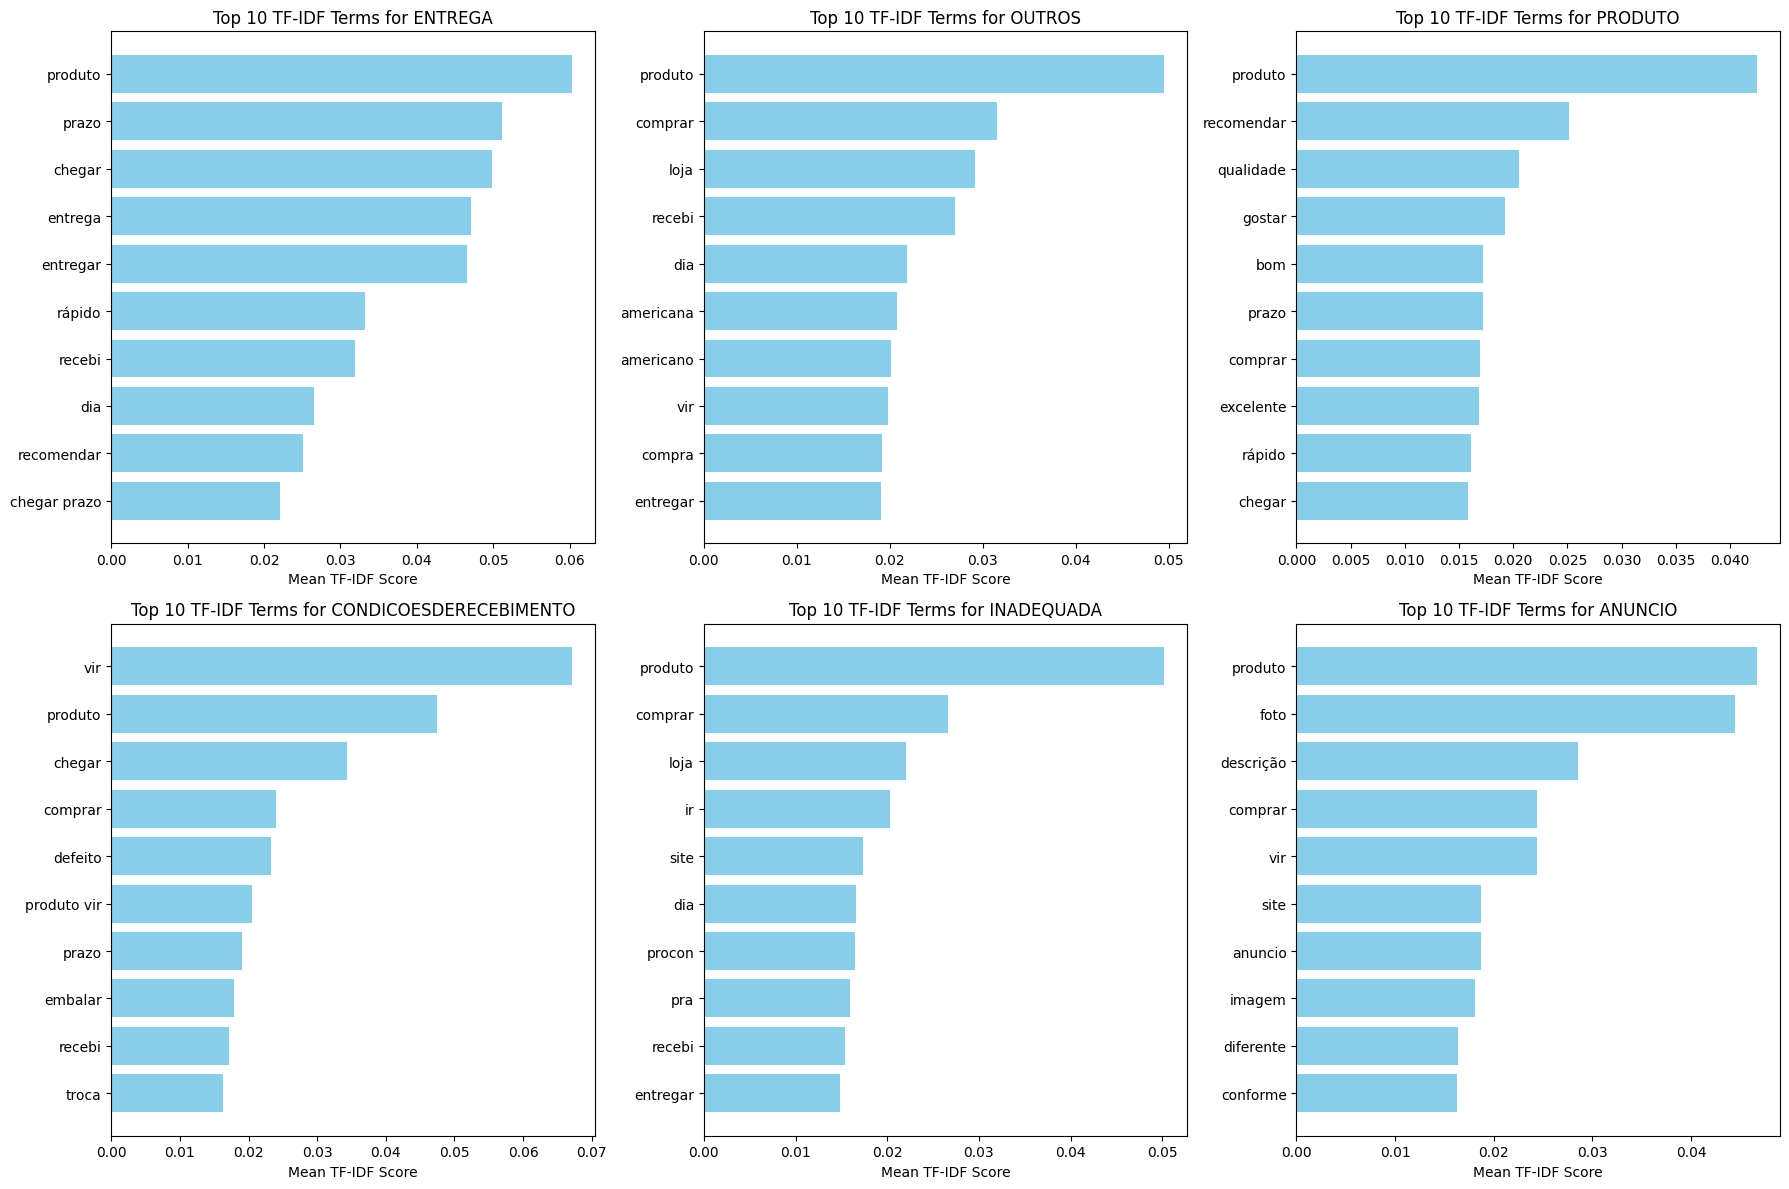

In [25]:
label_names = ['ENTREGA', 'OUTROS', 'PRODUTO', 'CONDICOESDERECEBIMENTO', 'INADEQUADA', 'ANUNCIO']

y_train = train_data[label_names].to_numpy()
print("y_train shape:", y_train.shape)

n_top = 10  # Number of top terms to show per label
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid for 6 labels
axes = axes.flatten()

for i, label in enumerate(label_names):
    # Indices of reviews where this label is true (1)
    label_indices = np.where(y_train[:, i] == 1)[0]
    # Average TF-IDF scores for those reviews
    label_tfidf = X_train_tfidf_bi[label_indices].mean(axis=0).A1  # Convert sparse to 1D array
    # Get top N terms
    top_indices = np.argsort(label_tfidf)[-n_top:][::-1]  # Sort descending
    top_terms = feature_names_bi[top_indices]
    top_scores = label_tfidf[top_indices]

    # Step 5: Plot horizontal bar chart
    axes[i].barh(top_terms, top_scores, color='skyblue')
    axes[i].set_title(f'Top {n_top} TF-IDF Terms for {label}')
    axes[i].set_xlabel('Mean TF-IDF Score')
    axes[i].invert_yaxis()  # Highest score at top

# Adjust layout and display
plt.tight_layout()
plt.show()

In [26]:
"""# Word cloud with top 50
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_words_bi[:50]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Distribution: Top 50 TF-IDF (Unigrams + Bigrams)")
plt.show()"""

'# Word cloud with top 50\nwordcloud = WordCloud(width=800, height=400, background_color=\'white\').generate_from_frequencies(dict(sorted_words_bi[:50]))\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud, interpolation=\'bilinear\')\nplt.axis(\'off\')\nplt.title("Word Distribution: Top 50 TF-IDF (Unigrams + Bigrams)")\nplt.show()'

### Feature Space

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # Unigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 9824


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Unigrams and bigrams
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 69115


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)  # Unigrams and bigrams only keeping the terms that occur more than 2 times
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 11400


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000 ,ngram_range=(1, 2))  # Unigrams and bigrams with maximum number of features
X = vectorizer.fit_transform(train_data['lemmatized_reviews'])
print("Feature space size:", len(vectorizer.get_feature_names_out()))

Feature space size: 10000


After applying TF-IDF vectorization with unigrams and bigrams our dataset, after preprocessing and vectorization, has generated a vocabulary of 69115 unique features (terms can be unigrams or bigrams).


min_df=2 -> 11400\
min_df=3 -> 6142


This is the dimensionality of our feature space—each review is represented as a sparse vector with 69115 possible positions, where most values are zero (since a single review uses only a tiny fraction of the vocabulary).

Our feature space is much larger than our sample size, this can lead to sparsity, where most feature values are zero, and potentially overfitting if not handled carefully. To address this high dimensionality and reduce noise from rare terms, we set min_df=2 in the TfidfVectorizer, excluding terms that appear in fewer than two reviews. This reduced the feature space to 11400 features, making it more manageable while retaining meaningful unigrams and bigrams. This adjustment helps mitigate sparsity and overfitting by focusing the model on terms with broader relevance across the dataset, balancing computational efficiency and classification performance

# **❗COMPARAR RESULTADOS COM MAX_FEATURES, MIN_DF...❗**

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

# Define variants
vectorizers = {
    "full": TfidfVectorizer(ngram_range=(1, 2)),
    "min_df=2": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
    "max_features=10000": TfidfVectorizer(ngram_range=(1, 2), max_features=10000),
    "max_features=5000": TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
}

for name, vec in vectorizers.items():
    X_train = vec.fit_transform(train_texts)  # Your preprocessed training data
    X_val = vec.transform(val_texts)      # Validation data
    clf = OneVsRestClassifier(MultinomialNB())
    clf.fit(X_train, y_train)             # Your multi-label y_train
    y_pred = clf.predict(X_val)
    macro_f1 = f1_score(y_val, y_pred, average='macro')
    print(f"{name}: Feature space size = {X_train.shape[1]}, Macro F1 = {macro_f1}")


## **2- Word2Vec**

In [31]:
"""#! pip install --upgrade numpy scipy gensim
# Desinstale as versões atuais
!pip uninstall -y gensim numpy

# Instale versões específicas compatíveis
!pip install numpy==1.24.3
!pip install gensim==4.3.2"""

'#! pip install --upgrade numpy scipy gensim\n# Desinstale as versões atuais\n!pip uninstall -y gensim numpy\n\n# Instale versões específicas compatíveis\n!pip install numpy==1.24.3\n!pip install gensim==4.3.2'

In [33]:
from gensim.models import Word2Vec

ImportError: cannot import name 'triu' from 'scipy.linalg' (/usr/local/lib/python3.11/dist-packages/scipy/linalg/__init__.py)

In [ ]:
break

## **Models Training**

``One-vs-Rest (OvR)`` não é um classificador em si, mas uma estratégia para transformar classificadores binários (como Naive Bayes e Regressão Logística) em modelos que suportam multi-label ou multi-classe.

O ``Multinomial Naive Bayes (MultinomialNB)`` é um modelo estatístico ideal para classificação de texto porque:

✅ Lida bem com representações baseadas em frequência, como Bag-of-Words e TF-IDF.\
✅ É eficiente e rápido, pois calcula probabilidades de forma simples.\
✅ Funciona bem para problemas onde as palavras aparecem independentemente, como em reviews de produtos.

### Baseline Classifier - Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
baseline_clf = OneVsRestClassifier(MultinomialNB())

### Other classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))

"""Train on the training set, tune hyperparameters on the validation set (e.g., C for Logistic Regression, max_depth for Random Forest), and evaluate on the test set later.
Justify choices: Logistic Regression is robust for text classification, SVM excels with high-dimensional data like TF-IDF, etc.
Since your dataset is imbalanced (e.g., PRODUTO: 6258 vs. INADEQUADA: 328), consider:

Class weighting: For Logistic Regression or SVM, set class_weight='balanced' to give more importance to rare labels.
XGBoost: It handles imbalance well with scale_pos_weight.
"""

## **Evaluation**

## **Error Analysis**
For your best model (highest macro-F1, say), analyze misclassifications:

* False Positives/Negatives: Look at reviews where the model predicted a label incorrectly. Are short reviews (e.g., 1 word) harder to classify? Are rare labels (INADEQUADA) often missed due to imbalance?
* Feature Importance: For Logistic Regression, check the top TF-IDF features per label (highest coefficients). Do they make sense (e.g., "atraso" for ENTREGA)?
* Confusion: Since it’s multi-label, examine label co-occurrence (e.g., PRODUTO + ENTREGA misclassified as just PRODUTO).

### Future Work
Sparse TF-IDF (5000 dimensions): Right now, you’re using a method called TF-IDF to turn each review into a list of 5000 numbers. Most of those numbers are zero (that’s why it’s "sparse"), and only a few have values that show which words matter in that review.

Potentially hybrid with Word2Vec later: You could add another method, Word2Vec, which makes a shorter list of numbers (e.g., 100) that capture what words mean. If you mix TF-IDF and Word2Vec together, you get a "hybrid" set of features—some numbers for word importance and some for word meaning.


### Potentially Hybrid with Word2Vec Later
Word2Vec: This is a different way to turn words into numbers. Instead of counting how often words appear (like TF-IDF), it learns what words mean by looking at their context in your reviews.
How it works: It creates a small list of numbers (e.g., 100, called "dimensions") for each word, where similar words (e.g., "entrega" and "chegar") get similar lists.
Example: "comprar" might be [0.2, -0.1, 0.5, ...] (100 numbers), and "compra" might be close to it, like [0.25, -0.08, 0.48, ...].
For a review: You average the Word2Vec lists of all words in a review to get one 100-number list for the whole text.
Dense: Unlike TF-IDF, where most of the 5000 numbers are zero (sparse), Word2Vec’s 100 numbers are all non-zero (dense), packed with meaning.
Hybrid: You can combine TF-IDF and Word2Vec:
Take your TF-IDF list (5000 numbers, sparse).
Add your Word2Vec list (100 numbers, dense).
Result: A 5100-number list per review, mixing word importance (TF-IDF) and word meaning (Word2Vec).
Why? TF-IDF catches key words (e.g., "atrasada" for ENTREGA), while Word2Vec catches relationships (e.g., "atrasada" is like "tarde").

### How This Ties to Model Choice
Current (TF-IDF Only): Logistic Regression or SVM loves sparse TF-IDF because they’re designed for high-dimensional, sparse data.
Hybrid (TF-IDF + Word2Vec): Random Forest or XGBoost might shine because they handle mixed sparse + dense features well, capturing both frequency and semantics.
For now, your dataset uses sparse TF-IDF (5000 dimensions). Adding Word2Vec later could boost performance if your baseline struggles—say, if macro-F1 is low due to label overlap (e.g., ENTREGA vs. CONDICOESDERECEBIMENTO).